In [1]:
!nvidia-smi

Tue Jan 10 13:03:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                  Off |
| N/A   38C    P0    66W / 300W |   1180MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:00:06.0 Off |                  Off |
| N/A   

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoConfig, AutoTokenizer

In [3]:
# dpath = '/content/drive/My Drive/Seculayer/KSRC/'
train = pd.read_csv('data/train_data.csv',encoding='utf-8')
test = pd.read_csv('data/test_data.csv',encoding='utf-8')
eval_klue = pd.read_json("data/klue-nli-v1.1_dev.json")
train_klue = pd.read_json("data/klue-nli-v1.1_train.json")
train.head()

,index,premise,hypothesis,label
0,0,"씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서, 소년이나 장정들이...",씨름의 여자들의 놀이이다.,contradiction
1,1,"삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나,...",자작극을 벌인 이는 3명이다.,contradiction
2,2,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다.,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4,"진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면, 이런 상황에서는...",이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [4]:
train_klue.tail()

,guid,genre,premise,hypothesis,gold_label,author,label2,label3,label4,label5
24993,klue-nli-v1_train_24993,wikitree,"힐링푸드 전문가 양성 교육 참여, 개발 음식 활용 등의 혜택도 주어진다.",개발 음식 활용 혜택만 주어진다.,contradiction,contradiction,contradiction,contradiction,contradiction,contradiction
24994,klue-nli-v1_train_24994,wikitree,"힐링푸드 전문가 양성 교육 참여, 개발 음식 활용 등의 혜택도 주어진다.",힐링푸드 전문가에게 혜택이 주어진다.,neutral,neutral,contradiction,neutral,neutral,contradiction
24995,klue-nli-v1_train_24995,wikitree,"힐링푸드 전문가 양성 교육 참여, 개발 음식 활용 등의 혜택도 주어진다.",혜택에는 힐링푸드 전문가 양성 교육 참여가 있다.,entailment,entailment,entailment,entailment,entailment,entailment
24996,klue-nli-v1_train_24996,NSMC,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 그 어떤 히어로보다 별로다.,contradiction,contradiction,contradiction,contradiction,contradiction,contradiction
24997,klue-nli-v1_train_24997,NSMC,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 액션 장면 진심 그 어떤 히어로보다 멋지다.,neutral,neutral,neutral,neutral,neutral,neutral


In [5]:
eval_klue.tail()

,guid,source,premise,hypothesis,gold_label,author,label2,label3,label4,label5
2995,klue-nli-v1_dev_02995,wikinews,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사는 중단없이 마무리 되었다.,contradiction,contradiction,contradiction,contradiction,contradiction,contradiction
2996,klue-nli-v1_dev_02996,wikinews,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선을 넓히는 공사가 중단된 건 세 번째이다.,neutral,neutral,neutral,neutral,neutral,neutral
2997,klue-nli-v1_dev_02997,wikinews,흔히 비자림로라고 불리는 지방도 제1112호선을 넓히는 공사가 1년만에 재개되었다가...,지방도 제1112호선은 흔히 비자림로라고 불린다.,entailment,entailment,entailment,entailment,entailment,entailment
2998,klue-nli-v1_dev_02998,airbnb,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,비흡연자는 발코니 있는 방이 필요없습니다.,neutral,neutral,neutral,neutral,neutral,neutral
2999,klue-nli-v1_dev_02999,airbnb,흡연자분들은 발코니가 있는 방이면 발코니에서 흡연이 가능합니다.,흡연하려면 발코니 있는 방을 선택하면 됩니다.,entailment,entailment,entailment,entailment,entailment,entailment


In [5]:
need_concat_train = train_klue.rename(columns={"gold_label":"label"}).iloc[:,2:5]
need_concat_eval = eval_klue.rename(columns={"gold_label":"label"}).iloc[:,2:5]

In [6]:
train = pd.concat([train,need_concat_train,need_concat_eval])

In [7]:
# 결측치는 없음

print(train.info(), end='\n\n')
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52996 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       24998 non-null  float64
 1   premise     52996 non-null  object 
 2   hypothesis  52996 non-null  object 
 3   label       52996 non-null  object 
dtypes: float64(1), object(3)
memory usage: 2.0+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       1666 non-null   int64 
 1   premise     1666 non-null   object
 2   hypothesis  1666 non-null   object
 3   label       1666 non-null   object
dtypes: int64(1), object(3)
memory usage: 52.2+ KB
None


In [8]:
print('Train Label: ', train['label'].value_counts(), sep='\n', end='\n\n')

Train Label: 
entailment       18122
contradiction    17978
neutral          16896
Name: label, dtype: int64



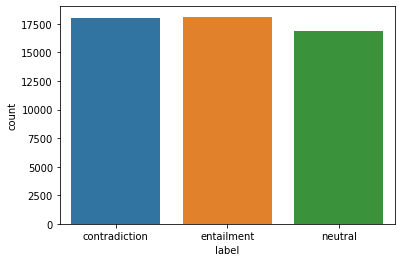

In [9]:
# data imbalance는 사실상 존재하지 않음 

sns.countplot(data=train,x='label');

In [10]:
max_premise = np.max(train['premise'].str.len())

max_hypothesis = np.max(train['hypothesis'].str.len())

In [11]:
print('max premise =',max_premise,"\nmax hypothesis =",max_hypothesis)

max premise = 90 
max hypothesis = 103


ValueError: cannot reindex from a duplicate axis

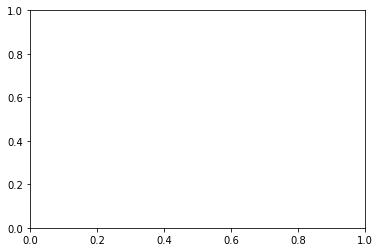

In [13]:
sns.histplot(x=train['premise'].str.len());

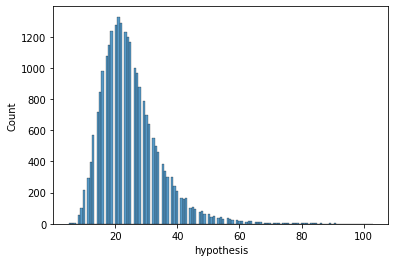

In [ ]:
sns.histplot(x=train['hypothesis'].str.len());

In [ ]:
english_list = []
english_count = 0

for i in range(0,len(train)):
    if train['premise'].str[:][i].upper() != train['premise'].str[:][i].lower():
        english_list.append(train['premise'].str[:][i])
        english_count += 1
    else:
        pass

In [ ]:
# 한국어로만 이루어진 데이터임을 확인 
english_list

[]

In [10]:
# 불 용어 처리 

train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['premise'] = test['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


,index,premise,hypothesis,label
0,0.0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다.,contradiction
1,1.0,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다.,contradiction
2,2.0,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다.,entailment
3,3.0,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다.,neutral
4,4.0,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다.,neutral


In [11]:
train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
test['hypothesis'] = test['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
train.head(5)

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,index,premise,hypothesis,label
0,0.0,씨름은 상고시대로부터 전해져 내려오는 남자들의 대표적인 놀이로서 소년이나 장정들이 ...,씨름의 여자들의 놀이이다,contradiction
1,1.0,삼성은 자작극을 벌인 2명에게 형사 고소 등의 법적 대응을 검토 중이라고 하였으나 ...,자작극을 벌인 이는 3명이다,contradiction
2,2.0,이를 위해 예측적 범죄예방 시스템을 구축하고 고도화한다,예측적 범죄예방 시스템 구축하고 고도화하는 것은 목적이 있기 때문이다,entailment
3,3.0,광주광역시가 재개발 정비사업 원주민들에 대한 종합대책을 마련하는 등 원주민 보호에 ...,원주민들은 종합대책에 만족했다,neutral
4,4.0,진정 소비자와 직원들에게 사랑 받는 기업으로 오래 지속되고 싶으면 이런 상황에서는 ...,이런 상황에서 책임 있는 모습을 보여주는 기업은 아주 드물다,neutral


In [10]:
def seed_everything(seed:int = 2023):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [19]:
MODEL_NAME = 'klue/roberta-large'

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3
config.learning_rate = 2.5e-05
config.warmup_ratio = 0.09
config.weight_decay = 0.007

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

print(model)
print(config)

loading file vocab.txt from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/vocab.txt
loading file tokenizer.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer_config.json
loading configuration file config.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/config.json
Model config RobertaConfig {
  "_name_or_path": "klue/robert

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32000, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
         

In [20]:
# train test split 및 tokenizing 
# token에 들어가는 문장은 premise와 hypothesis를 concat 한 문장

train_dataset, eval_dataset = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'])

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=210, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=210,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

print(tokenized_train['input_ids'][0])
print(tokenizer.decode(tokenized_train['input_ids'][0]))

tensor([    0, 15368,  2242,  2052,  1545, 19364,  2016,  8664,  1733,  3930,
         2116, 25848,  2530,  2170,  3653,  8664,  3992,  5005,  2170, 10686,
         2069,  7794,  2088,  1513,  2062,     2,  1545, 19364,  2016,  8664,
         1733,  3930,  2259,  5562,  4780,  2200, 25848, 19521,  1513,  2062,
            2,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1])
[CLS] 해남군이 제25호 태풍 콩레이가 북상함에 따라 태풍 피해 예방에 총력을 기울이고 있다 [SEP] 제25호 태풍 콩레이는 빠른 속도로 북상하고 있다 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

In [21]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [22]:
def label_to_num(label):
    label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label


train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)

In [23]:
train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)

print(train_dataset.__len__())
print(train_dataset.__getitem__(19997))
print(tokenizer.decode(train_dataset.__getitem__(19997)['input_ids']))

42396
{'input_ids': tensor([    0, 11896,  2290,   544,    22,  2628,  2170,  2318,  7714,    21,
         2353,  2154,  2252,  4639,  2290,   544,    22,  2628,  2170,  2318,
         2259,  7714,  3956,  2154,  2252,  9889,  2290,   544,    24,  2628,
         2170,  2318,  2259,  7714,  3740,  2154,  2252,  2052,  4589,  2897,
         2062,     2, 11896,  2290,  2073,   864,  1823,  2069,  1220,  2259,
         2062,     2,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [25]:
training_ars = TrainingArguments(
    output_dir='result/simple_roberta_more_epoch/',
    num_train_epochs=10,
    per_device_train_batch_size=32,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps = 500,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [26]:
trainer.train()
model.save_pretrained('result/simple_roberta_more_epoch/best_model')

/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 42396
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 6630
  Number of trainable parameters = 336659459
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sangmi. Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
500,0.458300,0.333561,0.896792
1000,0.228000,0.240110,0.930000
1500,0.153400,0.266176,0.930566
2000,0.107500,0.227783,0.945660
2500,0.075000,0.211995,0.957264
3000,0.058000,0.183834,0.959906
3500,0.046500,0.208669,0.963302
4000,0.031100,0.214016,0.964151
4500,0.020600,0.216754,0.963585
5000,0.015700,0.185620,0.970849


***** Running Evaluation *****
  Num examples = 10600
  Batch size = 16
Saving model checkpoint to result/simple_roberta_more_epoch/checkpoint-500
Configuration saved in result/simple_roberta_more_epoch/checkpoint-500/config.json
Model weights saved in result/simple_roberta_more_epoch/checkpoint-500/pytorch_model.bin
tokenizer config file saved in result/simple_roberta_more_epoch/checkpoint-500/tokenizer_config.json
Special tokens file saved in result/simple_roberta_more_epoch/checkpoint-500/special_tokens_map.json
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 10600
  Batch size = 16
Saving model checkpoint to result/simple_roberta_more_epoch/checkpoint-1000
Configuration saved in result/si

Special tokens file saved in result/simple_roberta_more_epoch/checkpoint-5000/special_tokens_map.json
Deleting older checkpoint [result/simple_roberta_more_epoch/checkpoint-2500] due to args.save_total_limit
/home/centos/anaconda3/envs/test_env/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
***** Running Evaluation *****
  Num examples = 10600
  Batch size = 16
Saving model checkpoint to result/simple_roberta_more_epoch/checkpoint-5500
Configuration saved in result/simple_roberta_more_epoch/checkpoint-5500/config.json
Model weights saved in result/simple_roberta_more_epoch/checkpoint-5500/pytorch_model.bin
tokenizer config file saved in result/simple_roberta_more_epoch/checkpoint-5500/tokenizer_config.json
Special tokens file saved in result/simple_roberta_more_epoch/checkpo

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "klue/roberta-large"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = 'result/simple_roberta_more_epoch/checkpoint-5000'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

print(tokenizer)

loading file vocab.txt from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/vocab.txt
loading file tokenizer.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/special_tokens_map.json
loading file tokenizer_config.json from cache at /home/centos/.cache/huggingface/hub/models--klue--roberta-large/snapshots/5193b95701189160c45d02a1033a4ea55bdbe259/tokenizer_config.json
loading configuration file result/simple_roberta_more_epoch/checkpoint-5000/config.json
Model config RobertaConfig {
  "_name_or_path": "result/simple_roberta_more_epoch/checkpoint-5000",
  "architectures": [
    "RobertaForSequenceClassifi

PreTrainedTokenizerFast(name_or_path='klue/roberta-large', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [33]:
test_label = label_to_num(test['label'].values)

tokenized_test = tokenizer(
    list(test['premise']),
    list(test['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

test_dataset = BERTDataset(tokenized_test, test_label)

print(test_dataset.__len__())
print(test_dataset.__getitem__(1665))
print(tokenizer.decode(test_dataset.__getitem__(6)['input_ids']))

1666
{'input_ids': tensor([    0,   720,  3994,  2052, 10428,  2775,   647,  3657,  2119,  1085,
            3,     2,   720,  3994,  2052,   911,  2075,  3669,  2119,  3926,
         2088,  1513,  2359, 13964,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [34]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
print(pred_answer)

100%|██████████| 105/105 [00:07<00:00, 14.88it/s]

[1, 0, 2, 1, 1, 2, 2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 1, 2, 1, 2, 1, 2, 1, 0, 1, 1, 2, 0, 0, 2, 1, 0, 1, 1, 2, 1, 0, 1, 0, 1, 2, 0, 2, 2, 2, 1, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 2, 2, 2, 0, 0, 1, 2, 2, 2, 1, 2, 2, 2, 1, 0, 2, 0, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 0, 1, 2, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 1, 1, 2, 0, 0, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 2, 1, 0, 2, 0, 2, 1, 1, 2, 2, 0, 0, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 1, 2, 2, 2, 0, 1, 2, 2, 1, 2, 2, 1, 0, 2, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 1, 0, 2, 2, 0, 1, 2, 1, 2, 0, 0, 1, 0, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 0, 1, 1, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 0, 1, 2, 1, 1, 2, 0, 0, 

In [35]:
def num_to_label(label):
    label_dict = {0: "entailment", 1: "contradiction", 2: "neutral"}
    str_label = []

    for i, v in enumerate(label):
        str_label.append([i,label_dict[v]])
    
    return str_label

answer = num_to_label(pred_answer)
print(answer)

[[0, 'contradiction'], [1, 'entailment'], [2, 'neutral'], [3, 'contradiction'], [4, 'contradiction'], [5, 'neutral'], [6, 'neutral'], [7, 'contradiction'], [8, 'entailment'], [9, 'neutral'], [10, 'contradiction'], [11, 'entailment'], [12, 'contradiction'], [13, 'entailment'], [14, 'neutral'], [15, 'neutral'], [16, 'contradiction'], [17, 'neutral'], [18, 'contradiction'], [19, 'neutral'], [20, 'contradiction'], [21, 'neutral'], [22, 'contradiction'], [23, 'entailment'], [24, 'contradiction'], [25, 'contradiction'], [26, 'neutral'], [27, 'entailment'], [28, 'entailment'], [29, 'neutral'], [30, 'contradiction'], [31, 'entailment'], [32, 'contradiction'], [33, 'contradiction'], [34, 'neutral'], [35, 'contradiction'], [36, 'entailment'], [37, 'contradiction'], [38, 'entailment'], [39, 'contradiction'], [40, 'neutral'], [41, 'entailment'], [42, 'neutral'], [43, 'neutral'], [44, 'neutral'], [45, 'contradiction'], [46, 'neutral'], [47, 'entailment'], [48, 'contradiction'], [49, 'entailment'], 

In [36]:
df = pd.DataFrame(answer, columns=['index', 'label'])

df.to_csv('simple_roberta_tune.csv', index=False)

print(df)

      index          label
0         0  contradiction
1         1     entailment
2         2        neutral
3         3  contradiction
4         4  contradiction
...     ...            ...
1661   1661        neutral
1662   1662  contradiction
1663   1663        neutral
1664   1664        neutral
1665   1665  contradiction

[1666 rows x 2 columns]
